In [2]:
import pandas as pd
import matplotlib.pyplot as plt

#!/usr/bin/env python3

from itertools import product
from collections import deque

import os
import pandas as pd
import glob
import numpy as np

import datetime
from scipy import signal
import pywt

import pyarrow as pa
import pyarrow.parquet as pq
import json

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import sys

import sys
 
# adding Folder_2 to the system path
sys.path.insert(0, '../../bin/models/')
from nested_xval_utils import *
#from rfpimp import *

In [3]:
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = fsize-5
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

In [4]:
fs={'feature':['psd_t'], 'stacking':['horizontal'], 'dims':[['H0','H1','UP']], 'augment':[True]}
feature_sets=[dict(zip(fs, v)) for v in product(*fs.values())]

#d = {'n_folds':[5],'max_depth': [50], 'n_estimators': [120], 'class_wt':[None],'wl_thresh':[0, 0.001,.005],}
d = {'n_folds':[5],'max_depth': [100], 'n_estimators': [120], 'class_wt':[None, "balanced_subsample"],'wl_thresh':[0]}
#d = {'n_folds':[5],'max_depth': [100], 'n_estimators': [500], 'class_wt':[None, "balanced_subsample"]}
hyperp=[dict(zip(d, v)) for v in product(*d.values())]

params=[i | feature_sets[0] for i in hyperp]

In [38]:
params

[{'n_folds': 5,
  'max_depth': 100,
  'n_estimators': 120,
  'class_wt': None,
  'wl_thresh': 0,
  'feature': 'psd_t',
  'stacking': 'horizontal',
  'dims': ['H0', 'H1', 'UP'],
  'augment': True},
 {'n_folds': 5,
  'max_depth': 100,
  'n_estimators': 120,
  'class_wt': 'balanced_subsample',
  'wl_thresh': 0,
  'feature': 'psd_t',
  'stacking': 'horizontal',
  'dims': ['H0', 'H1', 'UP'],
  'augment': True}]

In [5]:
pq_list=[os.path.join('../../data/feature_sets/',f) for f in os.listdir(os.path.join( '../../data/feature_sets/'))]
#pd_list=[pd.read_parquet(pq) for pq in pq_list if ".pq" in pq]
meta_list=[read_meta(pq_fs) for pq_fs in pq_list if ".pq" in pq_fs]
meta_df=pd.DataFrame.from_records(meta_list)


######################
ambient_list= list(meta_df[meta_df.magnitude.isnull()].eq_name.unique())
event_list=meta_df[~meta_df.magnitude.isnull()].sort_values(['magnitude'], ascending=False).groupby("eq_name").count().sort_values(['station'], ascending=False).index.tolist()
full_list=ambient_list+event_list

#convert to rsn
full_list=meta_df[meta_df.eq_name.isin(full_list)].record_number.unique()

In [7]:
X_train, y_train, name_list, times, snr_metric=list_to_featurearrays(full_list[:5], params[0], test=False)

In [35]:
full_list[:5]

array([212, 4134, 585, 4131, 513], dtype=object)

In [47]:
35-6

29

In [12]:
list(name_list[:6])

['max1', 'max2', 'max3', 'max4', 'med', 'mad']

In [9]:
freq_array=np.array([30.        , 15.        , 10.        ,  7.5       ,  6.        ,
        5.        ,  4.28571429,  3.75      ,  3.33333333,  3.        ,
        2.72727273,  2.5       ,  2.30769231,  2.14285714,  2.        ,
        1.875     ,  1.76470588,  1.66666667,  1.57894737,  1.5       ,
        1.42857143,  1.36363636,  1.30434783,  1.25      ,  1.2       ,
        1.15384615,  1.11111111,  1.07142857,  1.03448276])

In [34]:
strings = ["%.1fs" % number for number in list(freq_array)]

In [35]:
new_names=list(name_list[:6])+(strings)

In [36]:
new_names

['max1',
 'max2',
 'max3',
 'max4',
 'med',
 'mad',
 '30.0s',
 '15.0s',
 '10.0s',
 '7.5s',
 '6.0s',
 '5.0s',
 '4.3s',
 '3.8s',
 '3.3s',
 '3.0s',
 '2.7s',
 '2.5s',
 '2.3s',
 '2.1s',
 '2.0s',
 '1.9s',
 '1.8s',
 '1.7s',
 '1.6s',
 '1.5s',
 '1.4s',
 '1.4s',
 '1.3s',
 '1.2s',
 '1.2s',
 '1.2s',
 '1.1s',
 '1.1s',
 '1.0s']

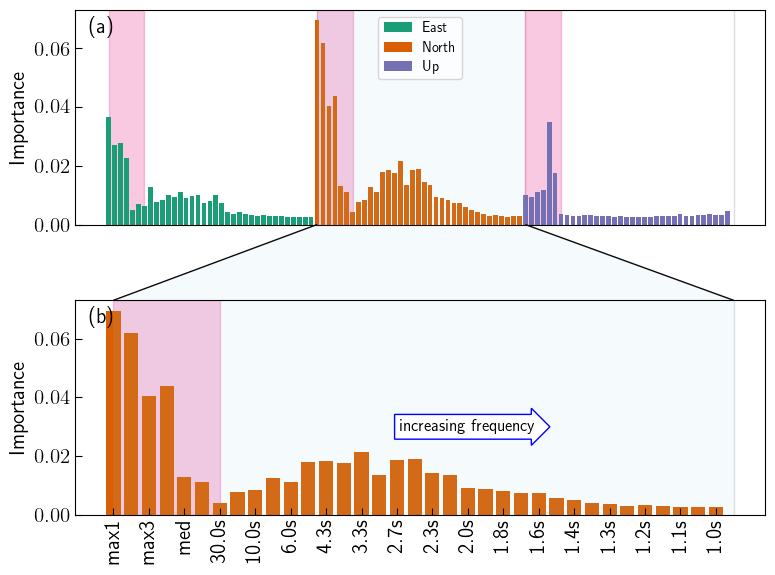

In [41]:
fig,ax=plt.subplots(2, 1,figsize=(8,6))

from matplotlib.patches import FancyBboxPatch
import matplotlib.transforms as mtransforms

#clf = joblib.load(os.path.join(os.path.dirname(os.getcwd()), 'data/model_all_40.pkl'))
clf = joblib.load('../../models/synth_model_all_40.pkl')
importances = list(clf.feature_importances_)
important_len=int(len(importances)/3)
val=35
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
#import matplotlib.pyplot as plt
#%matplotlib inline
# Set the style
#plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
my_colors=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
my_colors=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
direcs=['East','North','Up']
for i,color,direc in zip(np.arange(3),my_colors,direcs):
    ax[0].axvspan(i*(important_len), i*(important_len)+6, alpha=0.25, color=my_colors[3])
    ax[0].axvspan(i*(important_len)+6+29, i*(important_len)+6+29, alpha=0.25, color='grey')
    ax[0].bar(x_values[i*important_len:i*important_len+important_len], importances[i*important_len:i*important_len+important_len],  color=color, label=direc)
    
    
#ax[0].set_xlim([-1,248])
ax[0].legend()

#ax[0].fill_between(x, 0, 1, where=y > threshold,
#                color='green', alpha=0.5, transform=ax.get_xaxis_transform())



# Tick labels for x axis
ax[0].set_xticks([])
ax[0].set_ylabel('Importance')
trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
ax[0].text(0, 1.0, '(a)', transform=ax[0].transAxes + trans,
            fontsize='medium', verticalalignment='top')

i=1
ax[1].axvspan(i*(important_len), i*(important_len)+6, alpha=0.25, color=my_colors[3])
ax[1].axvspan(i*(important_len)+6+29, i*(important_len)+6+29, alpha=0.25, color='grey')
ax[1].bar(x_values[i*important_len:i*important_len+val], importances[i*important_len:i*important_len+val], orientation = 'vertical', color=my_colors[i])
ax[1].set_ylabel('Importance')

ax[1].text(0, 1.0, '(b)', transform=ax[1].transAxes + trans,
            fontsize='medium', verticalalignment='top')
#ax[1].bar(x_values[80:105], importances[80:105], orientation = 'vertical')
# Tick labels for x axis
name_list2=['4th Max','3rd Max','2nd Max','** Max','Median','Mad', 'SNR','* 30s','* 15s','* 10s','* 7.5s','* 6s','* 5s','4.3s','3.8s','3.3s','3s','2.7s','2.5s', '2.3s']
#ax[1].set_xticks(x_values[i*82:i*82+18], name_list[i*82:i*82+30], rotation='vertical')
ax[1].set_xticks(x_values[i*important_len:(i+1)*important_len][::2], new_names[:important_len][::2], rotation='vertical')

#ax[1].text(x_values[i*important_len]+20,0.015, '<<increasing frequency<<')
t = ax[1].text(
    x_values[i*important_len]+20,0.03, "increasing frequency", ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="b", lw=1))
'''
t = ax[1].text(
    x_values[i*important_len]+50+80,0.015, "increasing scale", ha="center", va="center", rotation=0, size=12,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="b", lw=2))

'''

from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)


def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
        }

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           # loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    Connect *ax1* and *ax2*. The *xmin*-to-*xmax* range in both axes will
    be marked.

    Parameters
    ----------
    ax1
        The main axes.
    ax2
        The zoomed axes.
    xmin, xmax
        The limits of the colored area in both plot axes.
    **kwargs
        Arguments passed to the patch constructor.
    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches = {**kwargs, "color":'#a6cee3',"ec": "none", "alpha": 0.1}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p


zoom_effect01(ax[0], ax[1], 35, 35+6+29)

##################
fig.tight_layout()
plt.savefig('figs/importances.png',dpi=300)
plt.show()

In [27]:
new_names[i*important_len:(i+1)*important_len]

[]

In [32]:
x_values

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104]

In [ ]:
x_test=pd.DataFrame(X_train, columns=name_list)
y_test=pd.DataFrame(y_train)

In [ ]:
#df.groupby('year').case_status.value_counts().unstack(0).plot.barh()
df.groupby('feature')[['precision','recall','f1']].mean().plot.bar()
plt.ylim([0.6,1])
plt.tight_layout()
plt.savefig('figs/feature_bar.png',dpi=300)

# Importances

In [27]:
###############  Generate list of samples by event
#pq_list=[os.path.join(os.path.dirname(os.getcwd()), 'data/feature_set/',f) \
#         for f in  os.listdir(os.path.join(os.path.dirname(os.getcwd()), 'data/feature_set/'))]

pq_list=[os.path.join('../../../snivel/data/feature_set/',f) for f in os.listdir('../../../snivel/data/feature_set/')]
meta_list=[read_meta(pq_fs) for pq_fs in pq_list if ".pq" in pq_fs]
meta_df=pd.DataFrame.from_records(meta_list)

In [28]:
fs={'feature':['all'], 'stacking':['horizontal'], 'dims':[['H0','H1','UP']], 'augment':[True]}
feature_sets=[dict(zip(fs, v)) for v in product(*fs.values())]

d = {'n_folds':[5],'max_depth': [100], 'n_estimators': [120], 'class_wt':[None],'wl_thresh':[0]}
hyperp=[dict(zip(d, v)) for v in product(*d.values())]

for features in feature_sets:
    params=[i | features for i in hyperp]

In [30]:
jgr_test=meta_df[(meta_df.radius_from_event<100) | (meta_df.radius_from_event==np.nan)]

threshold=.4

clf = joblib.load('../../models/synth_model_all_%s.pkl' %int(threshold*100))
#clf = joblib.load('results/aug/model_run_1.pkl')

X_test, y_test, name_list, times, snr_metric=list_to_featurearrays_JGR(jgr_test, params[0], test=True)

In [8]:
important_len

35

In [34]:
x_values[i*important_len:i*important_len+important_len]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181]